Let's go.

In [ ]:
import pandas as pd

In [ ]:
def openData():
    df=pd.read_csv("../data.csv")
    df.drop_duplicates()
    return df
house=openData()
house.info()
house=house.drop(['district','test'],axis=1)
house=house.dropna(subset=['price'])

just working a bit with the dataset to understand what's going on. you can pass this.

In [ ]:
print(house.describe())

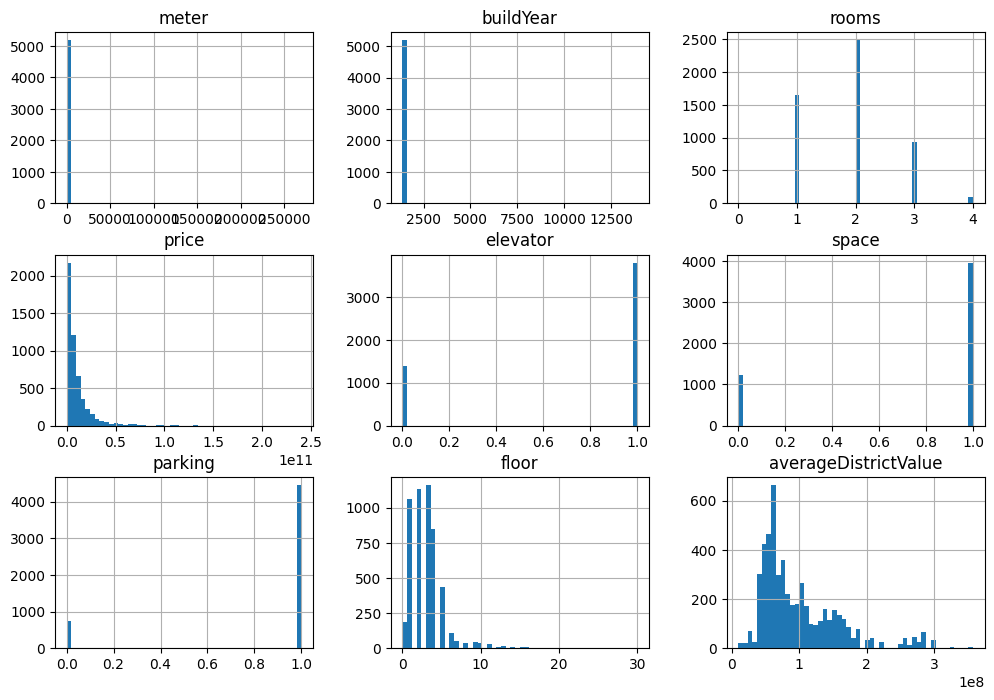

In [221]:
import matplotlib.pyplot as plt
house.hist(bins=50, figsize=(12, 8))
plt.show()

**Deleting the outliers**

In [222]:
import numpy as np
from scipy import stats
outlierHigh = house["price"].quantile(0.99)
outlierLow = house["price"].quantile(0.01)
house.reset_index()
house=house[(house['price'] > outlierLow) & (house['price'] < outlierHigh)]
house.describe()

,meter,buildYear,rooms,price,elevator,space,parking,floor,averageDistrictValue
count,5071.000000,5071.000000,5071.000000,5.071000e+03,5071.000000,5071.000000,5071.000000,5071.000000,5.071000e+03
mean,182.781305,1394.470519,1.880891,1.052393e+10,0.728653,0.759416,0.859791,2.978702,9.804357e+07
std,4219.591090,175.883136,0.743421,1.187249e+10,0.444698,0.427480,0.347238,2.318934,5.721519e+07
min,19.000000,1370.000000,0.000000,5.400000e+08,0.000000,0.000000,0.000000,0.000000,9.539284e+06
25%,59.000000,1385.000000,1.000000,3.300000e+09,0.000000,1.000000,1.000000,2.000000,5.723655e+07
50%,80.000000,1393.000000,2.000000,6.000000e+09,1.000000,1.000000,1.000000,3.000000,7.755518e+07
75%,112.000000,1400.000000,2.000000,1.300000e+10,1.000000,1.000000,1.000000,4.000000,1.292102e+08
max,270000.000000,13902.000000,4.000000,8.100000e+10,1.000000,1.000000,1.000000,30.000000,3.581995e+08


**making the test set**

In [223]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [224]:
house_with_id = house.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

count      5071.000000
mean        182.781305
std        4219.591090
min          19.000000
25%          59.000000
50%          80.000000
75%         112.000000
max      270000.000000
Name: meter, dtype: float64


Text(0, 0.5, 'Number of districts')

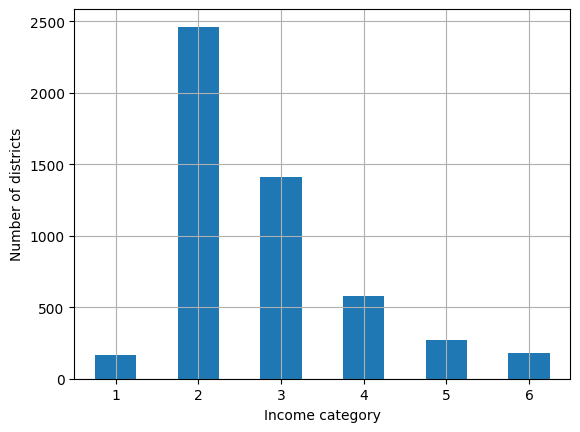

In [225]:
print(house['meter'].describe())
house["meter_cat"] = pd.cut(house["meter"].astype(float),
bins=[0., 40, 80, 120, 160, 200., np.inf],
labels=[1, 2, 3, 4, 5, 6])
house["meter_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [226]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(house, house["meter_cat"]):
    stratTrainSetN = house.iloc[trainIndex]
    stratTestSetN = house.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]

In [227]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("meter_cat", axis=1 , inplace=True)

/tmp/ipykernel_7751/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)
/tmp/ipykernel_7751/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [228]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price                   1.000000
averageDistrictValue    0.771607
rooms                   0.647275
space                   0.307771
elevator                0.303946
parking                 0.194947
floor                   0.153389
meter                   0.088377
buildYear              -0.001565
Name: price, dtype: float64


_note 1_ : wow it seems that meter is really important!

In [229]:

print(stratTrainSet.describe())
house = stratTrainSet.drop('price',axis=1)
labels = stratTrainSet[['price']].copy()
print(labels.describe())

               meter     buildYear        rooms         price     elevator  \
count    4056.000000   4056.000000  4056.000000  4.056000e+03  4056.000000   
mean      205.156558   1395.143984     1.878945  1.055798e+10     0.732742   
std      4717.892877    196.614308     0.743498  1.200913e+10     0.442583   
min        19.000000   1370.000000     0.000000  5.400000e+08     0.000000   
25%        59.000000   1385.000000     1.000000  3.307500e+09     0.000000   
50%        80.000000   1393.000000     2.000000  6.000000e+09     1.000000   
75%       112.000000   1400.000000     2.000000  1.300000e+10     1.000000   
max    270000.000000  13902.000000     4.000000  8.100000e+10     1.000000   

             space      parking        floor  averageDistrictValue  
count  4056.000000  4056.000000  4056.000000          4.056000e+03  
mean      0.764053     0.857495     2.950444          9.826129e+07  
std       0.424641     0.349610     2.273150          5.710730e+07  
min       0.000000   

imputation

In [230]:
def imputeFrequent(cols,h):
    for col in cols:
        frequent = house[col].mode()
        h[[col]]=h[[col]].fillna(float(frequent),inplace=False)
    return h
house = imputeFrequent(['floor','rooms','meter','buildYear'], house)
house.describe()


,meter,buildYear,rooms,elevator,space,parking,floor,averageDistrictValue
count,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4.056000e+03
mean,205.156558,1395.143984,1.878945,0.732742,0.764053,0.857495,2.950444,9.826129e+07
std,4717.892877,196.614308,0.743498,0.442583,0.424641,0.349610,2.273150,5.710730e+07
min,19.000000,1370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.539284e+06
25%,59.000000,1385.000000,1.000000,0.000000,1.000000,1.000000,2.000000,5.889515e+07
50%,80.000000,1393.000000,2.000000,1.000000,1.000000,1.000000,3.000000,7.787802e+07
75%,112.000000,1400.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.292102e+08
max,270000.000000,13902.000000,4.000000,1.000000,1.000000,1.000000,30.000000,3.581995e+08


*Handling district*

number attributes:

In [231]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
houseNum=house.select_dtypes(np.number)
housingNumStd = std_scaler.fit_transform(houseNum)

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(house[["meter"]])

**And finally The PIPELINE**

In [232]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
("impute", SimpleImputer(strategy='most_frequent')),
("standardize", StandardScaler()),
])
houseNumPrepared=num_pipeline.fit_transform(houseNum)
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"))

preprocessing = ColumnTransformer([
],remainder=num_pipeline)
housing_prepared = preprocessing.fit_transform(house)


**Train**

**Really, Really Testing for overfitting**

In [233]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=4))
print(sklearn.metrics.get_scorer_names())
forest_mae = -cross_val_score(forest_reg, house, labels['price'],cv=7,scoring="neg_mean_absolute_error")
forest_rmse = -cross_val_score(forest_reg, house, labels['price'],cv=7,scoring="neg_mean_squared_error")

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [234]:
from math import sqrt
print(sqrt(forest_rmse.mean())/1e9,forest_rmse.std())
print(forest_mae.mean()/1e9,forest_mae.std())
print(type(labels['price']))
forest_reg.fit(house,labels['price'])
housing_predictions = forest_reg.predict(house)
print(housing_predictions[:5]/1e9)
print(labels['price'][:5]/1e9)


3.7244724581543727 3.902784574232092e+18
1.7142755383040535 107379235.92207605
<class 'pandas.core.series.Series'>
[ 7.3968  12.12016 15.5066   4.45975  4.0922 ]
5174     6.8
3806    13.0
75      16.7
2719     4.4
1970     3.4
Name: price, dtype: float64
